# Importação das bibliotecas necessárias

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.stats import zscore, sem, wilcoxon, ttest_rel
from statsmodels.stats.multitest import multipletests as mt
import dataframe_image as dfi

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Definição de parâmetros úteis ao projeto

In [ ]:
# Definição do caminho onde se encontram os arquivos
caminho = 'https://github.com/gabrielliberato/pdpd-analise-de-neuroimagem/blob/main/'

# Leitura dos arquivos de triggers 


In [ ]:
TR_REPOUSO = pd.read_csv(f'{caminho}tarefa/triggers/trigger1.csv',
                          sep=',',
                          names=[f'CT{i+1}' for i in range(19)], skiprows=[5])

TR_MAOS_BRANCAS = pd.read_csv(f'{caminho}tarefa/triggers/trigger2.csv',
                              sep=',',
                              names=[f'MB{i + 1}' for i in range(10)], skiprows=[5])
TR_MAOS_NEGRAS = pd.read_csv(f'{caminho}tarefa/triggers/trigger3.csv',
                             sep=',',
                              names=[f'MN{i + 1}' for i in range(10)], skiprows=[5])
TR_TOTAL = pd.read_csv(f'{caminho}tarefa/triggers/triggerTotal.csv',
                             sep=',',
                             names=[f'T{i + 1}' for i in range(20)], skiprows=[5])

# Definição de alguns parâmetros necessários para a execução do script

CANAIS = [f'C{i+1}' for i in range(42)] # Nomeia os canais de C1 a C42
qtdCanais = len(CANAIS)
tarefa_oxy = f'{caminho}tarefa/tarefa_oxy' # extrai os dados do Google Drive
# arquivos = sorted(os.listdir(tarefa_oxy))
arquivos = ['2019-02-20_002.nirs_oxy.txt', '2019-02-22-01_002.nirs_oxy.txt', '2019-02-22-02_002.nirs_oxy.txt', '2019-02-22-03_002.nirs_oxy.txt', '2019-02-25_002.nirs_oxy.txt', '2019-03-08_002.nirs_oxy.txt', '2019-03-15_002.nirs_oxy.txt', '2019-03-22-02_002.nirs_oxy.txt', '2019-03-22_002.nirs_oxy.txt', '2019-04-26_002.nirs_oxy.txt', '2019-05-10_002.nirs_oxy.txt', '2019-05-15_002.nirs_oxy.txt', '2019-05-16_01_002.nirs_oxy.txt', '2019-05-16_02_002.nirs_oxy.txt', '2019-05-17_01_002.nirs_oxy.txt', '2019-05-17_02_002.nirs_oxy.txt', '2019-05-17_03_002.nirs_oxy.txt', '2019-05-17_04_002.nirs_oxy.txt', '2019-05-20_01_002.nirs_oxy.txt', '2019-05-20_02_002.nirs_oxy.txt', '2019-05-31_002.nirs_oxy.txt', '2019-07-12_002.nirs_oxy.txt', '2019-07-19-01_002.nirs_oxy.txt', '2019-07-19-02_002.nirs_oxy.txt', '2019-07-30_002.nirs_oxy.txt']
qtdSujeitos = len(arquivos)
sinalMedio = [[0 for lis in range(6000)] for lista in range(42)]
tamanhos = [4882, 4897, 4898, 4899, 4900, 4902, 4903, 4904, 4905, 4905, 4905, 4906, 4907, 4908, 4911, 4912, 4913, 4913, 4914, 4916, 4917, 4917, 4922, 4924, 4950]
base = [330, 431, 444, 325, 422, 400, 554, 394, 397, 443, 438, 422, 392, 412, 473, 347, 363, 453, 403, 503, 460, 621, 394, 409, 518]
sequencia = ["B", "N", "N", "B", "B", "N", "B", "N", "B", "B", "N", "N", "B", "N", "N", "B", "B", "N", "N", "B"]

# Sinal médio geral

In [ ]:
# Criação do sinal médio (referente à oxihemoglobina - HbO) para cada canal,
# considerando todos os sujeitos do experimento

oxyH = []
for sujeito in range(qtdSujeitos):

    NIRS_OXY = pd.read_csv(f'{tarefa_oxy}/{arquivos[sujeito]}?raw=true', sep='\t', names=CANAIS, skiprows=[sk for sk in range(base[sujeito])])
    oxyH.append(NIRS_OXY.iloc[:4882])
    oxyH[sujeito] = oxyH[sujeito].apply(zscore) # dados padronizados com o z-score
    for canal in range(qtdCanais):
      Y = oxyH[sujeito][CANAIS[canal]]
      sinalMedio[canal] = [x + y for x, y in zip(Y, sinalMedio[canal])]


In [ ]:
# Média dos sinais médios por canal

mediaSMedio = [[0 for _ in range(270)] for k in range(42)]
for ind, canal in enumerate(sinalMedio):
  inicio = 0
  fim = 270
  soma = [0 for k in range(270)]
  bloco = 0
  while fim <= len(canal):
    soma = [x + y for x, y in zip(soma, canal[inicio:fim])]
    inicio += 252
    fim += 252
    bloco += 1
  if fim > len(canal):
    j = canal[inicio:len(canal)]
    soma = [x + y for x, y in zip(soma, canal[inicio:len(canal)]  + [0 for _ in range(270-len(j))])]
    bloco += 1
  mediaSMedio[ind] =  [x/20 for x in soma]

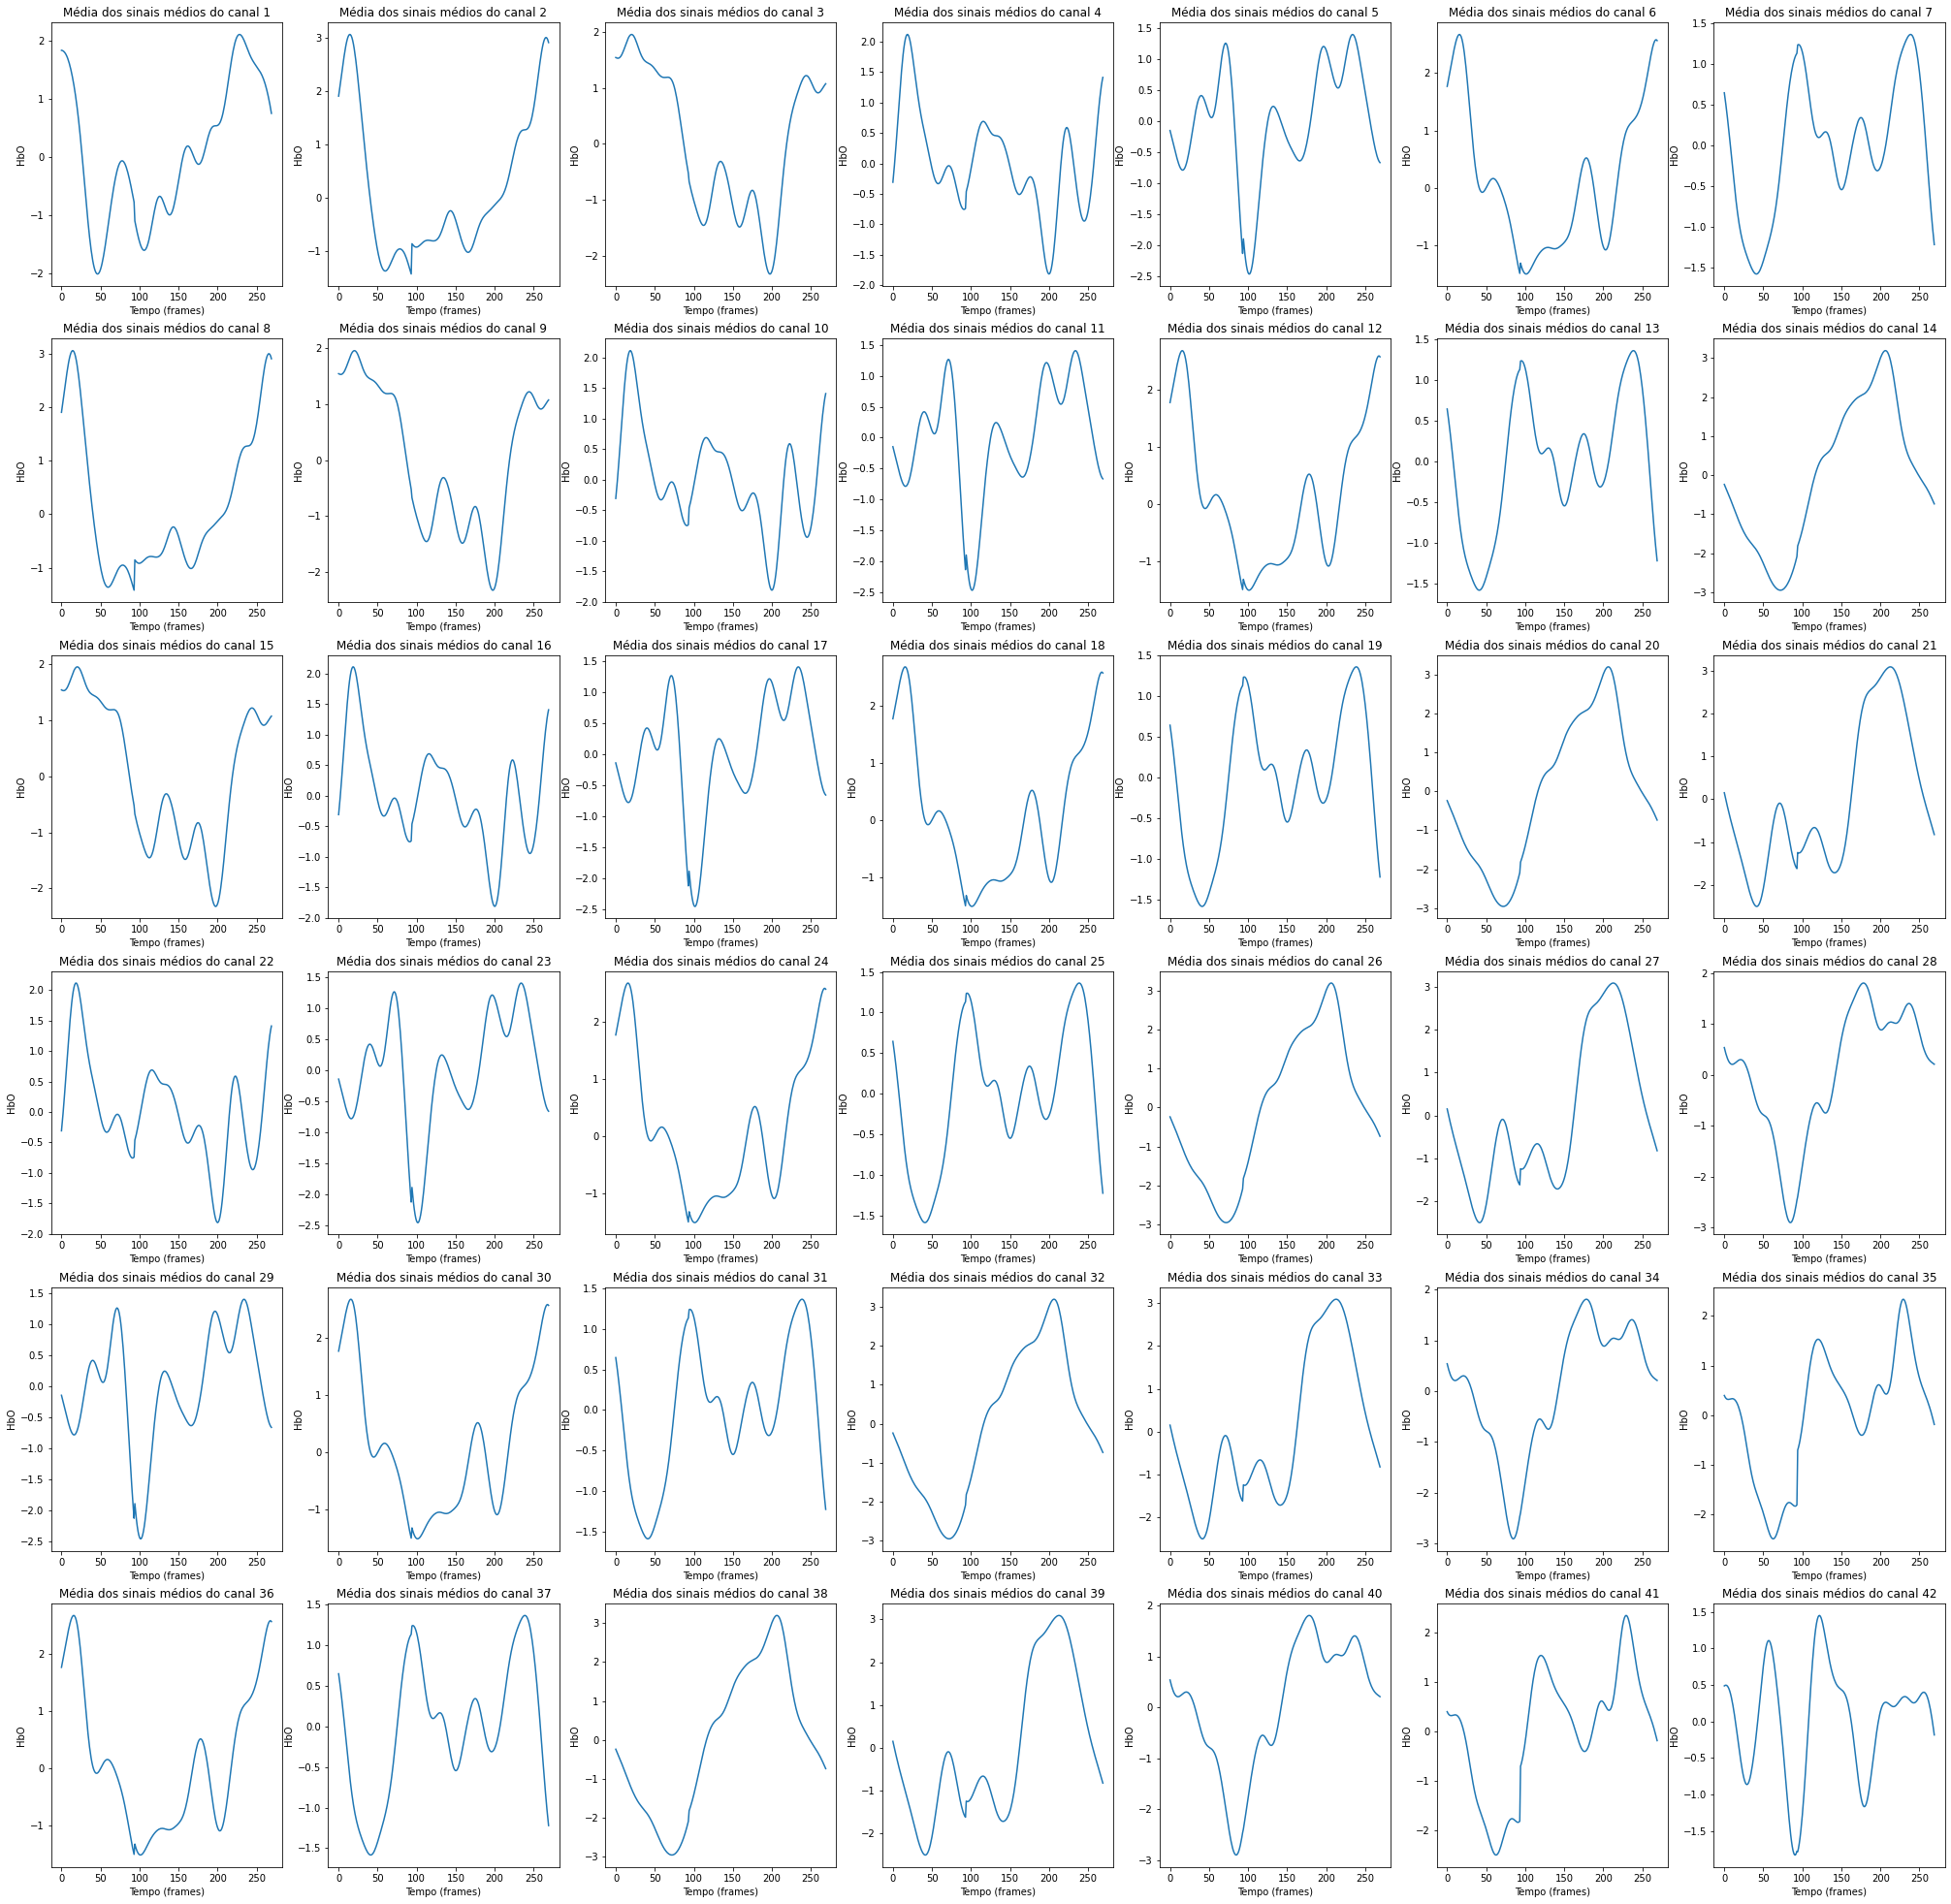

In [ ]:
fig, axs = plt.subplots(6, 7, figsize=(35, 35))
canal = 1
for k in range(6):
  for j in range(7):
    axs[k, j].plot(mediaSMedio[k+j])
    axs[k, j].set_title(f'Média dos sinais médios do canal {canal}')
    canal += 1
# fig.savefig('graficao', )
for ax in axs.flat:
    ax.set(xlabel='Tempo (frames)', ylabel='HbO')

# Sinal médio, por raça/etnia

In [ ]:
# Média dos sinais médios - por etnia/raça da mão apresentada

mediaSMedioBRANCA = [[0 for _ in range(270)] for k in range(42)]
mediaSMedioNEGRA = [[0 for _ in range(270)] for k in range(42)]

for ind, canal in enumerate(sinalMedio):
  inicio = 0
  fim = 270
  somaB = [0 for k in range(270)]
  somaN = [0 for k in range(270)]

  bloco = 0
  while fim <= len(canal):

    if sequencia[bloco] == "B":
      somaB = [x + y for x, y in zip(somaB, canal[inicio:fim])]
    elif sequencia[bloco] == "N":
      somaN = [x + y for x, y in zip(somaN, canal[inicio:fim])]

    inicio += 252
    fim += 252
    bloco += 1
  if fim > len(canal):
    j = canal[inicio:len(canal)]
    if sequencia[bloco] == "B":
      somaB = [x + y for x, y in zip(somaB, canal[inicio:len(canal)]  + [0 for _ in range(270-len(j))])]
    elif sequencia[bloco] == "N":
      somaN = [x + y for x, y in zip(somaN, canal[inicio:len(canal)]  + [0 for _ in range(270-len(j))])]

    bloco += 1

  mediaSMedioBRANCA[ind] =  [x/10 for x in somaB]
  mediaSMedioNEGRA[ind] =  [x/10 for x in somaN]

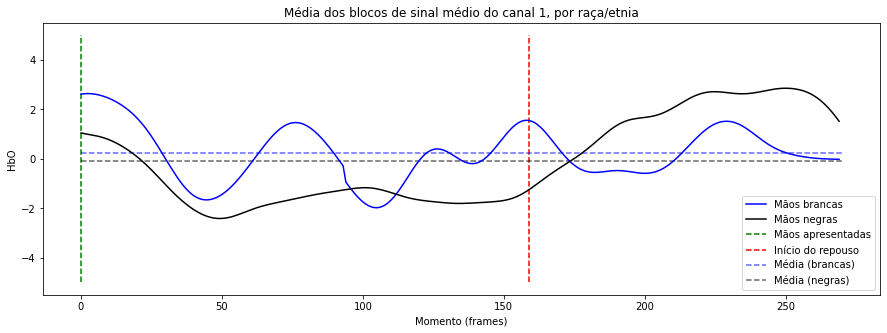

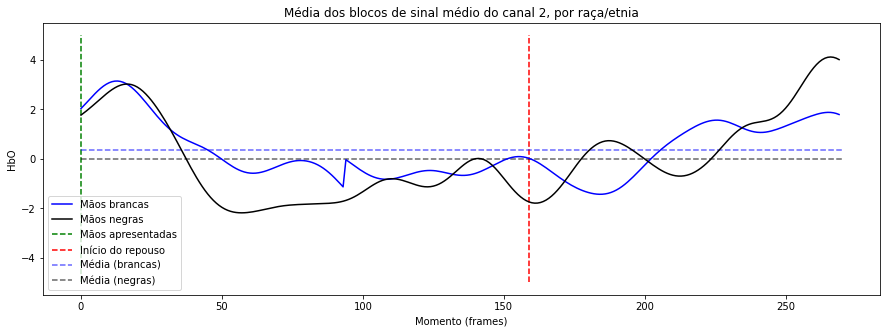

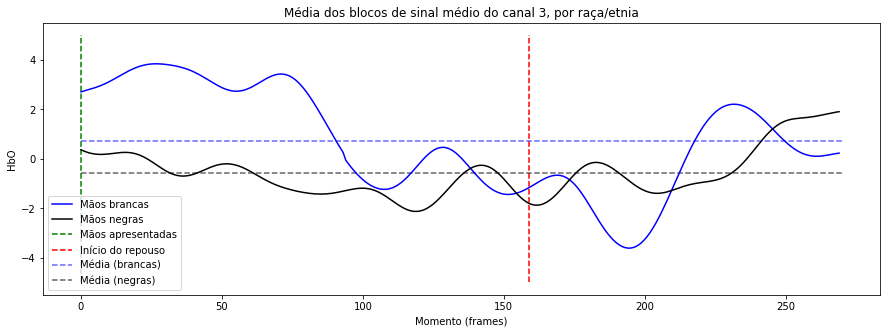

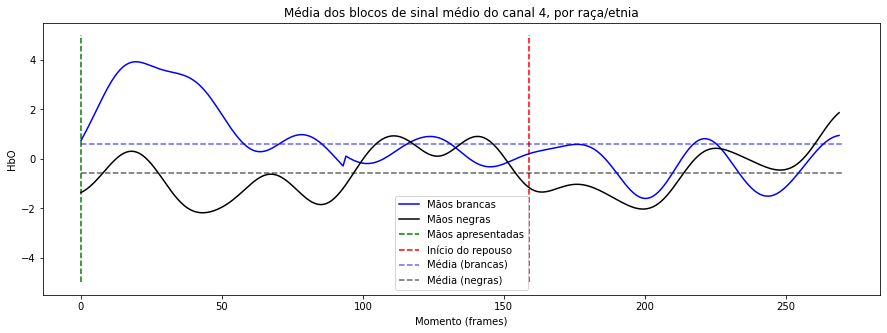

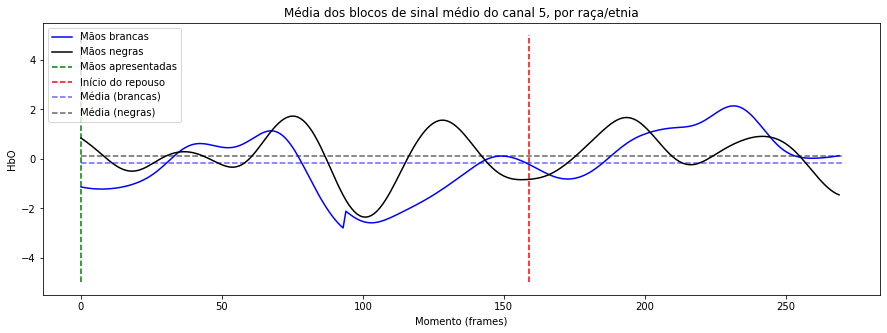

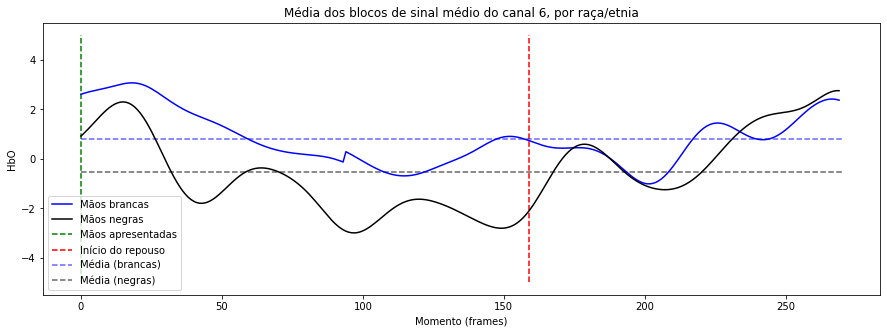

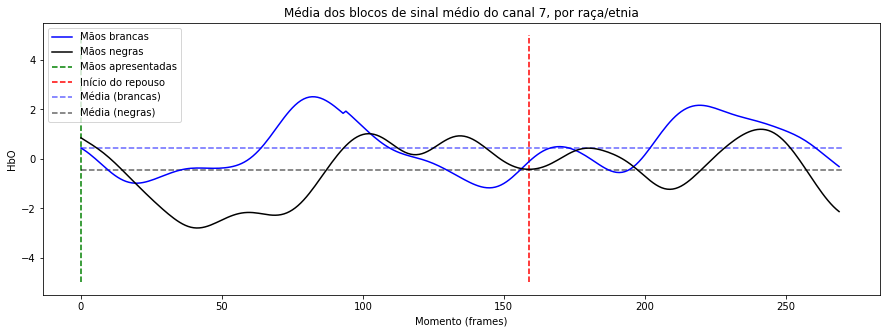

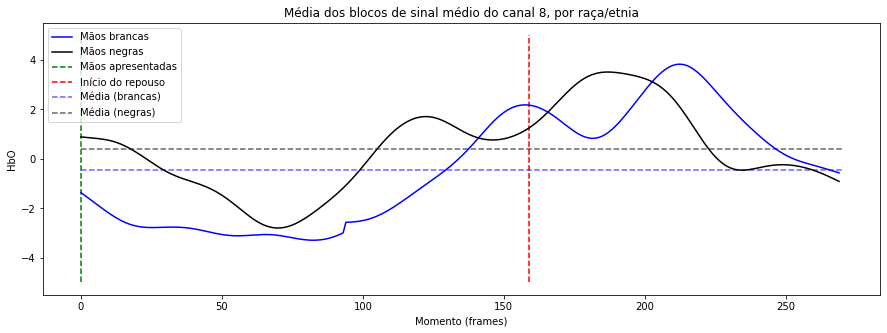

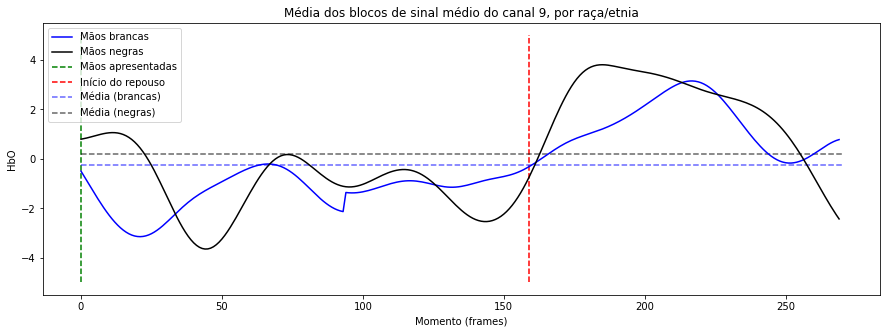

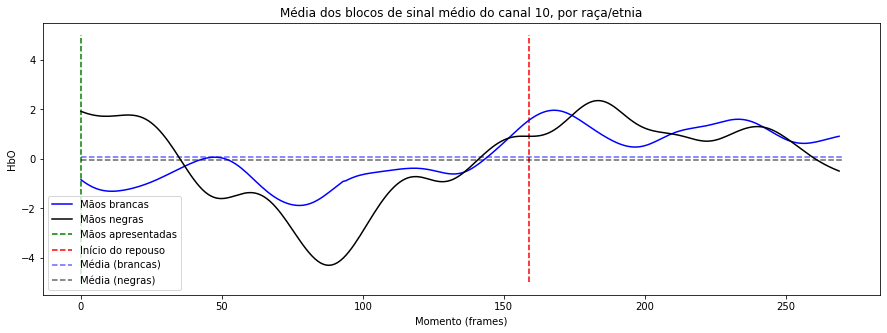

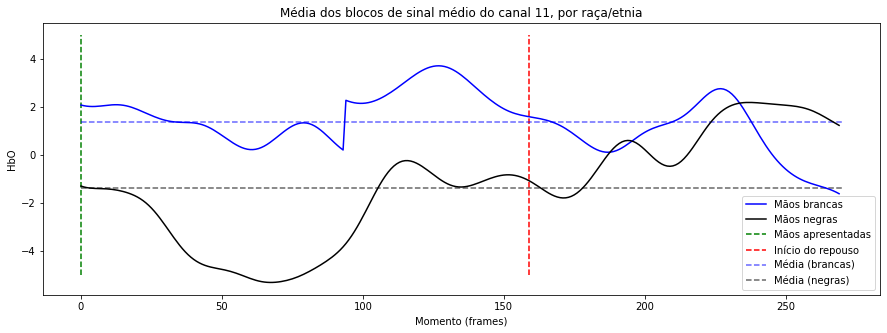

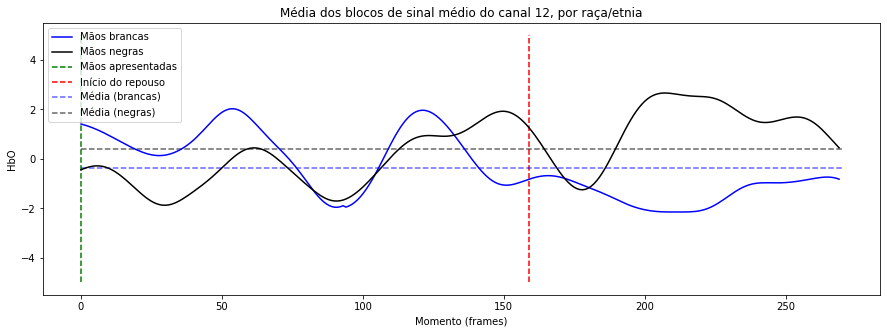

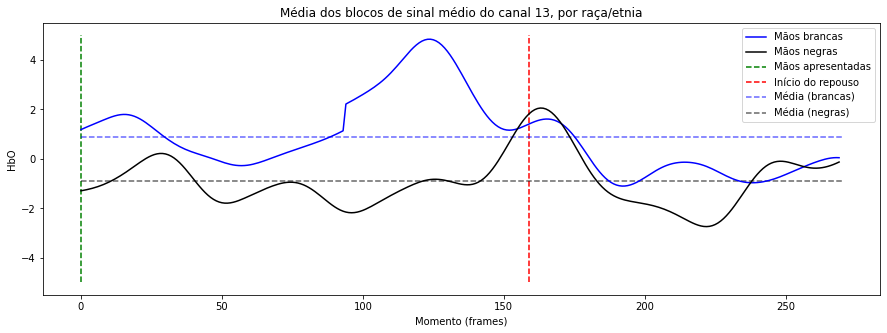

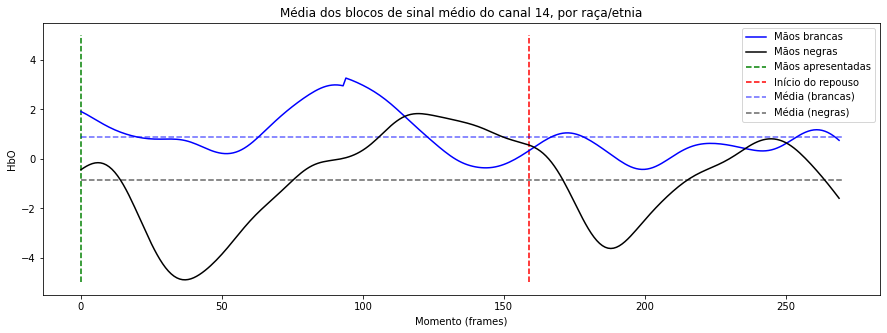

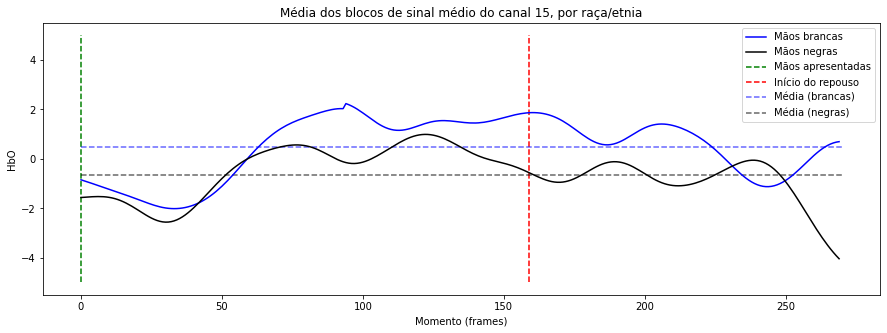

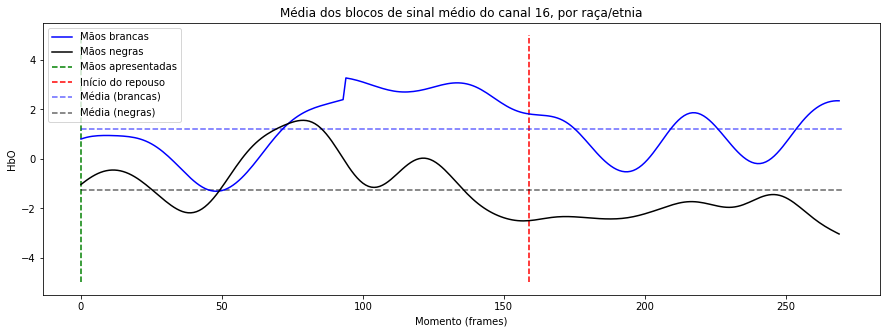

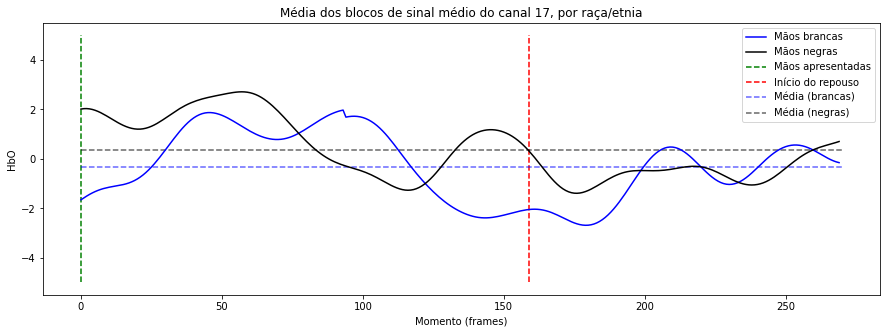

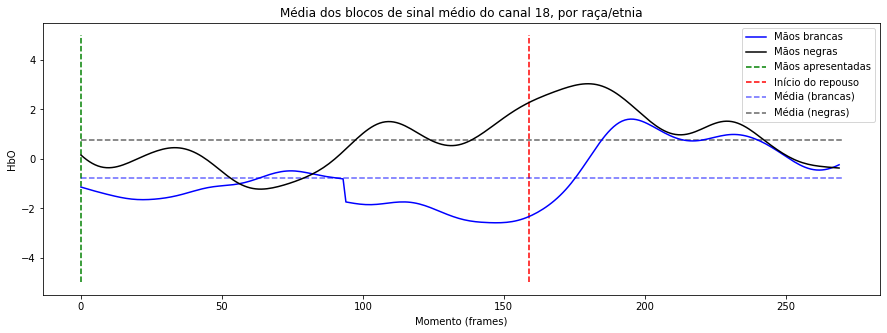

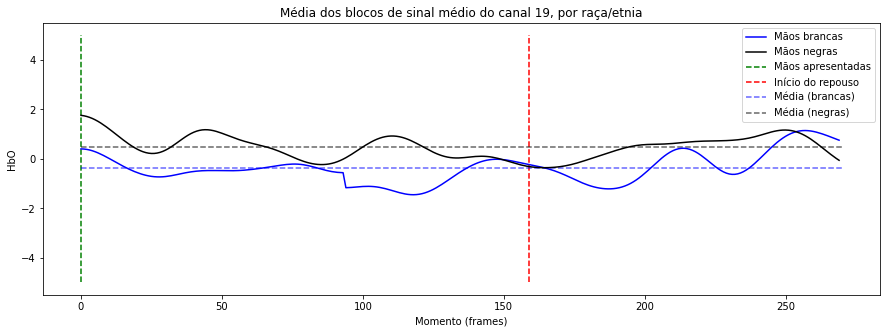

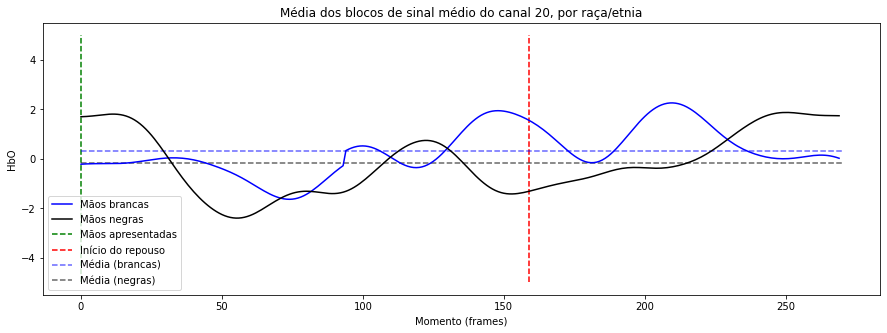

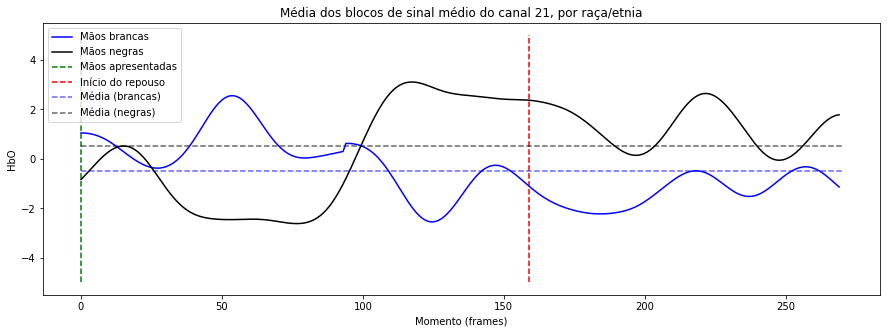

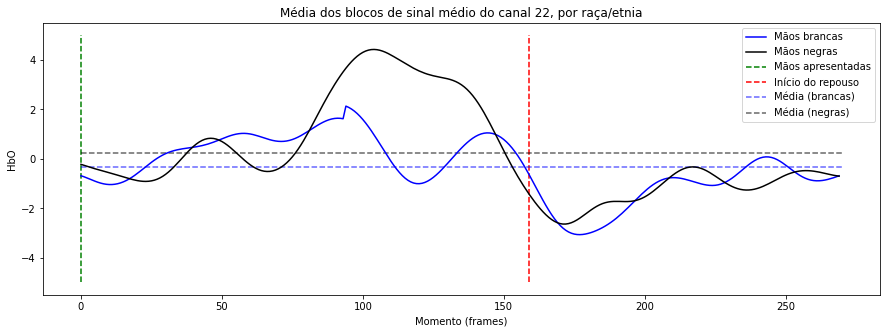

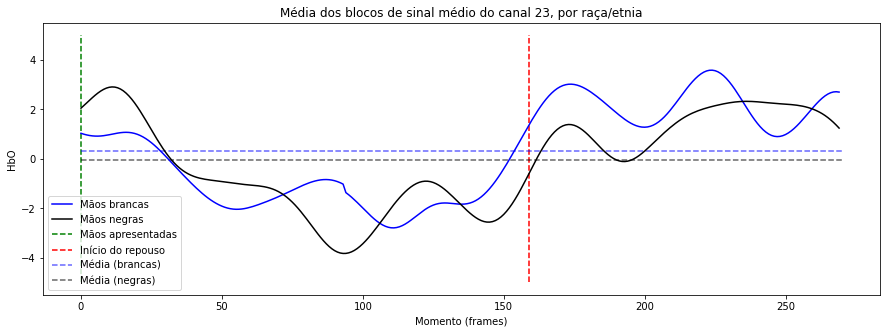

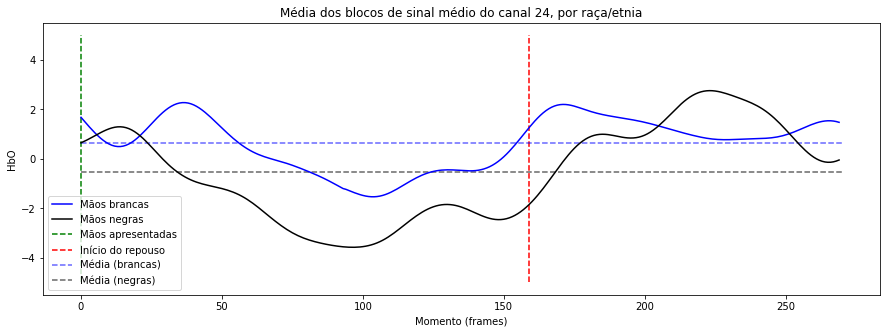

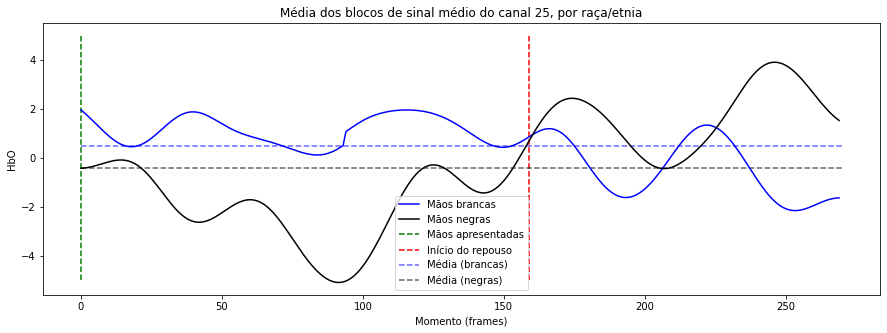

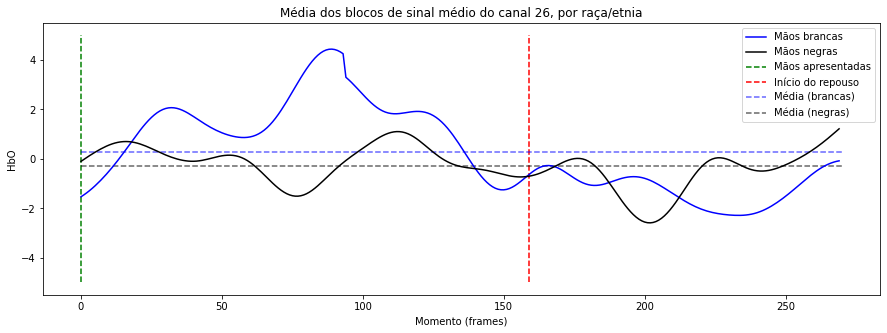

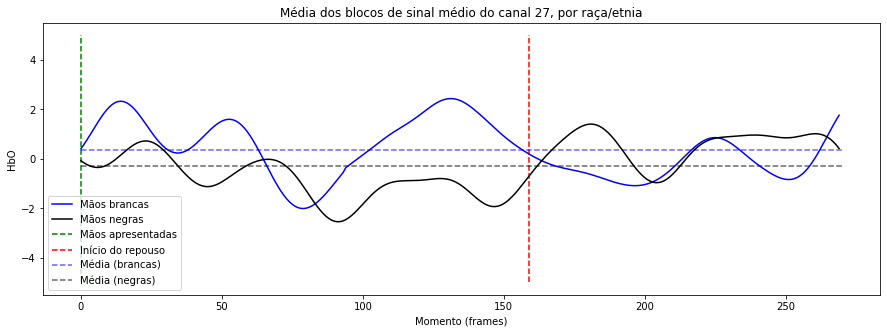

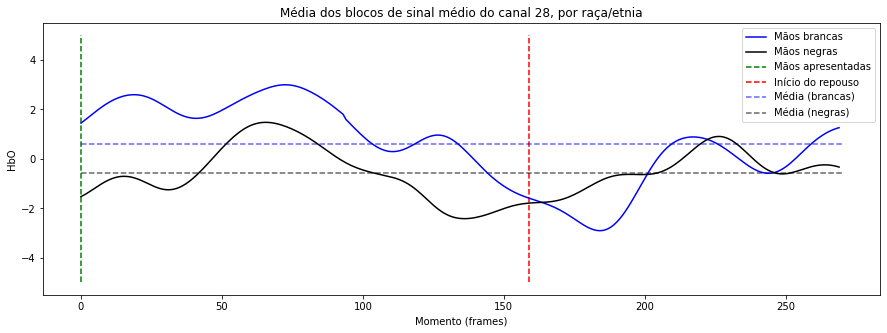

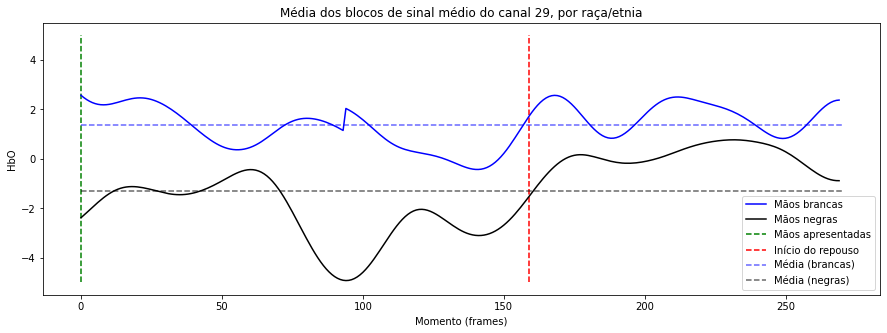

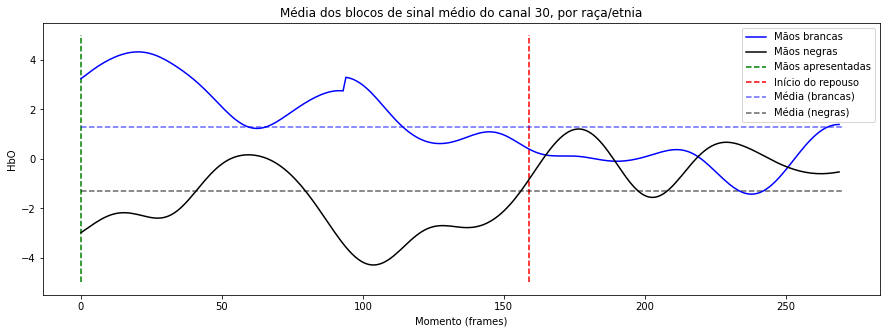

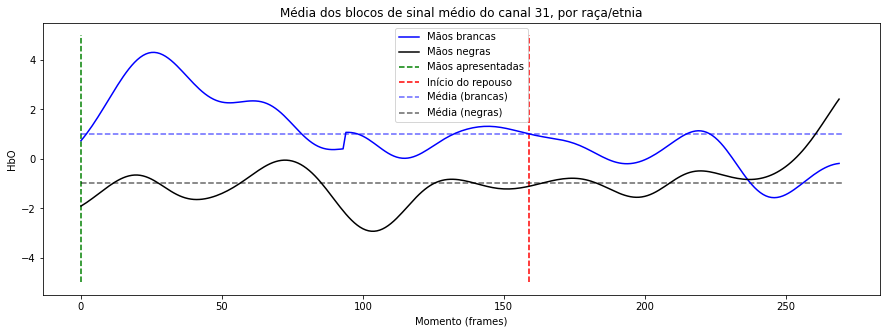

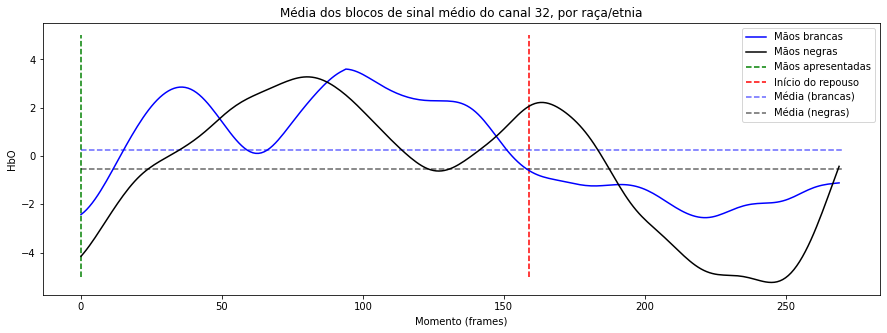

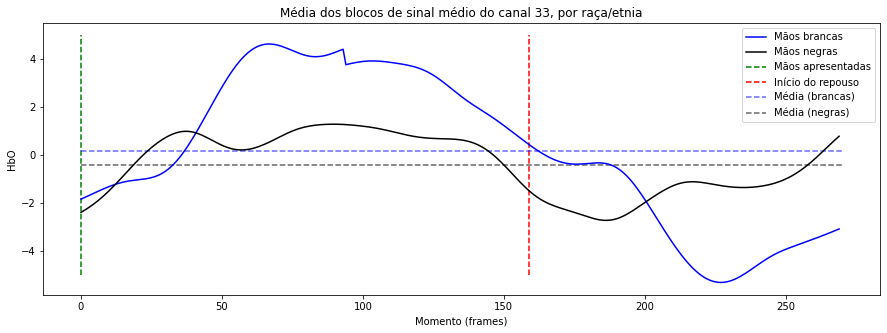

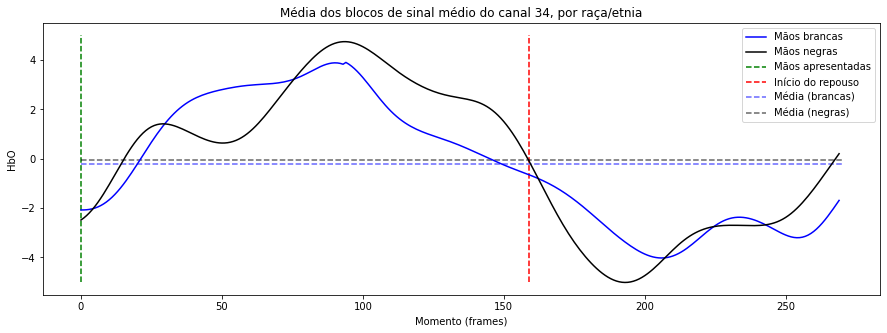

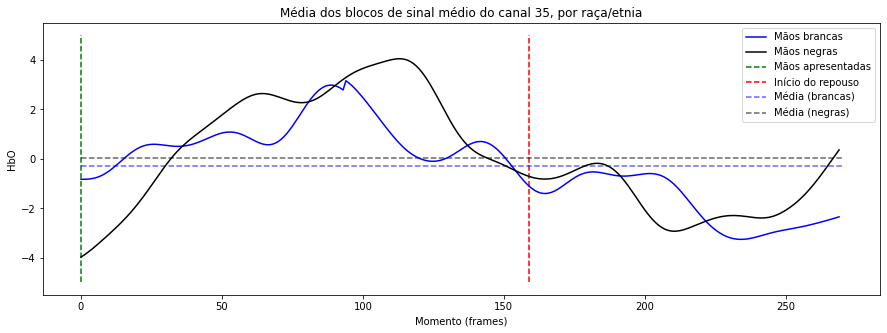

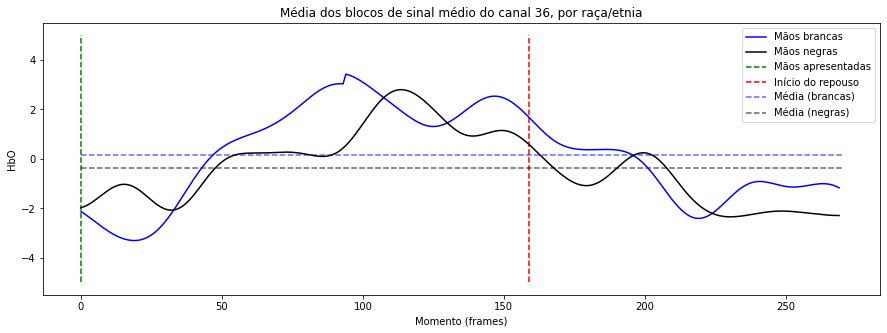

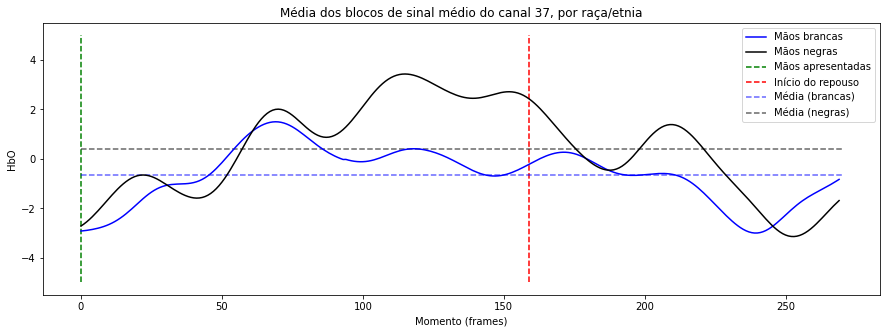

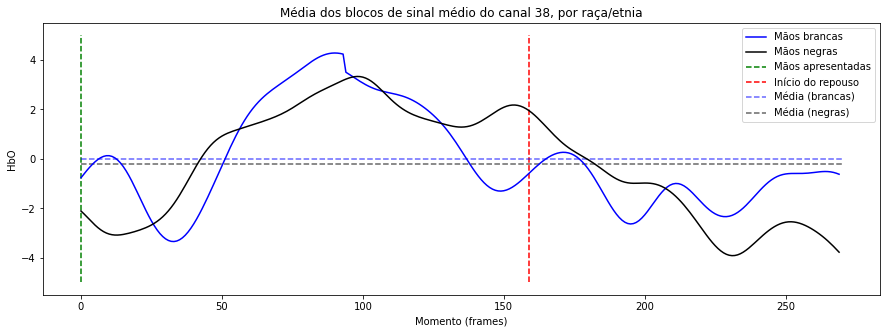

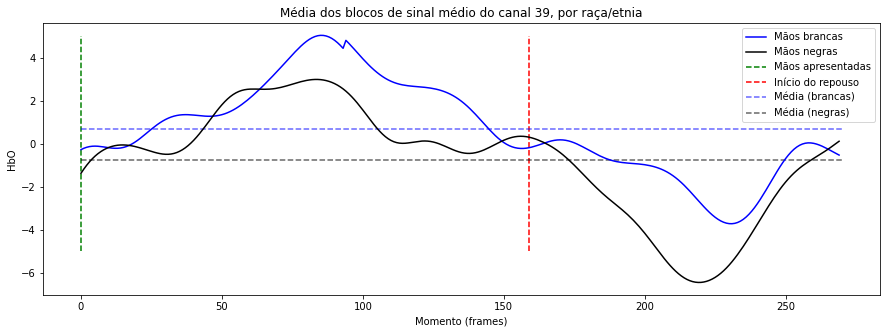

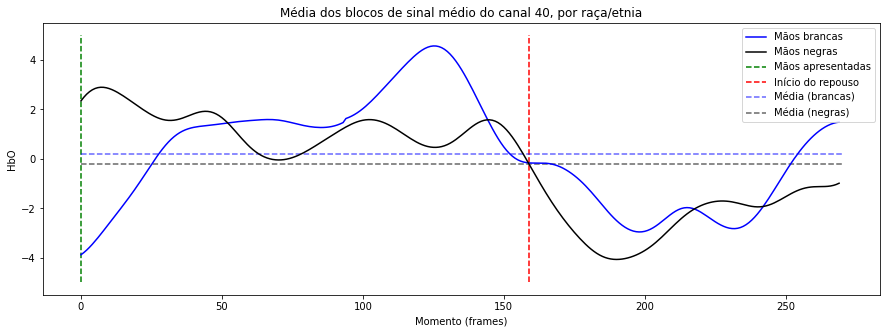

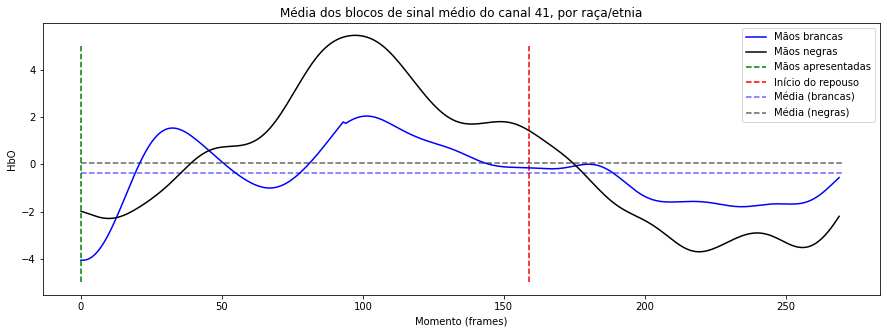

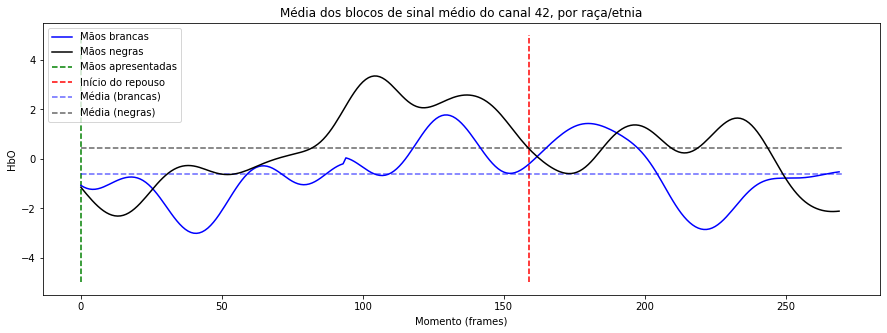

In [ ]:
validos = [22, 26, 28, 32, 33, 34, 35, 36]
mbcs = [sum(mediaSMedioBRANCA[i])/len(mediaSMedioBRANCA[i]) for i in range(42)]
mngs = [sum(mediaSMedioNEGRA[i])/len(mediaSMedioNEGRA[i]) for i in range(42)]
for i in range(42):
  plt.figure(figsize=(15, 5))
  plt.plot(mediaSMedioBRANCA[i], color="b")
  plt.plot(mediaSMedioNEGRA[i], color="black")
  plt.title(f"Média dos blocos de sinal médio do canal {i+1}, por raça/etnia")
  plt.vlines(0, -5, 5, linestyles='dashed', colors='g')
  plt.vlines(159, -5, 5, linestyles='dashed', colors='r')
  plt.xlabel("Momento (frames)")
  plt.ylabel("HbO")
  plt.show()

# Visualização da distribuição dos dados

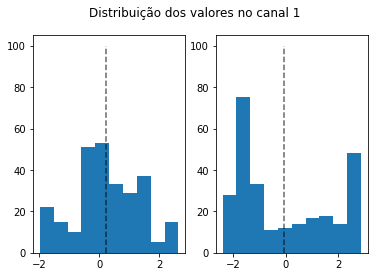

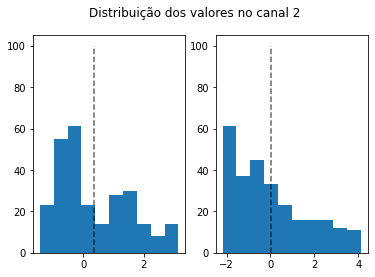

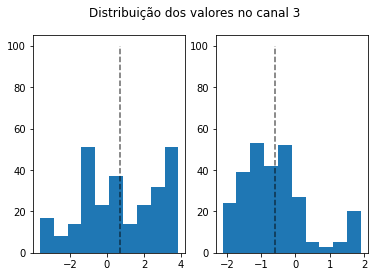

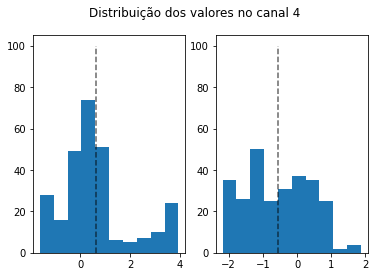

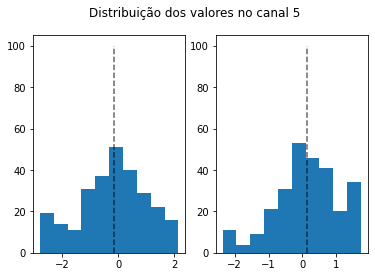

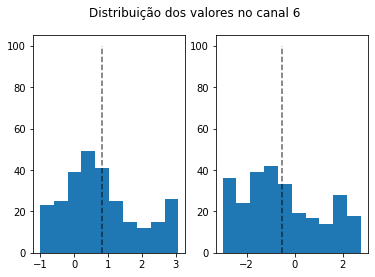

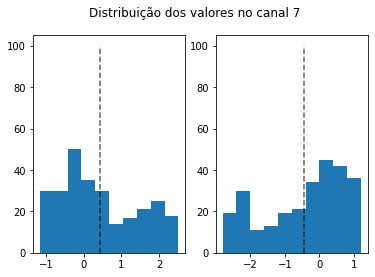

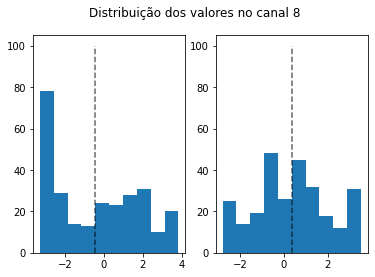

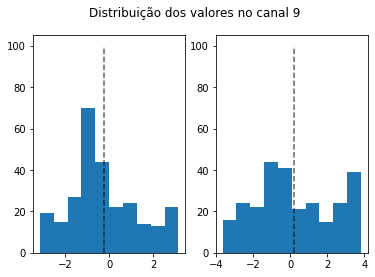

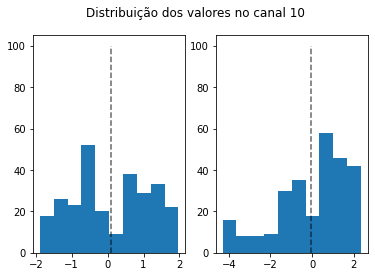

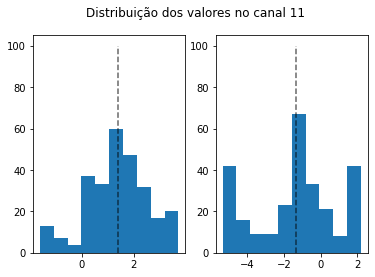

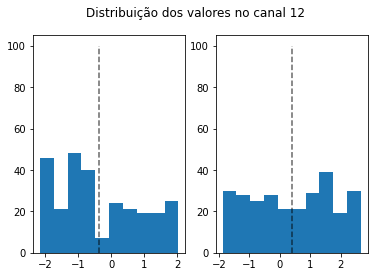

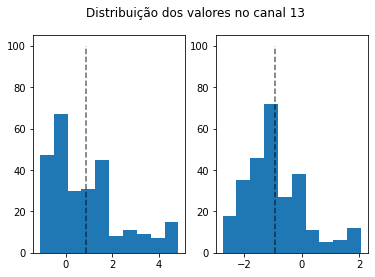

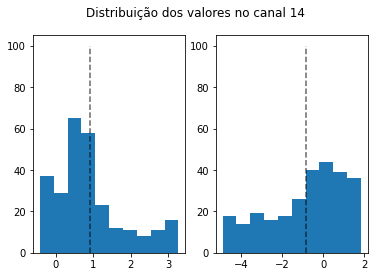

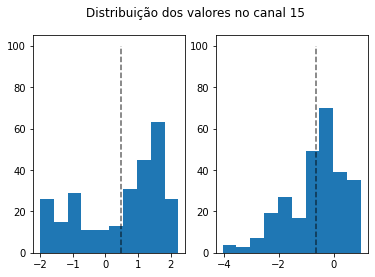

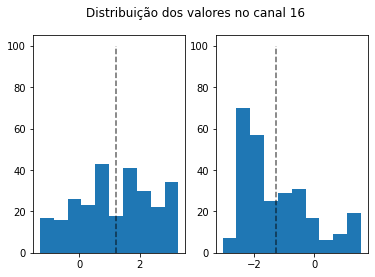

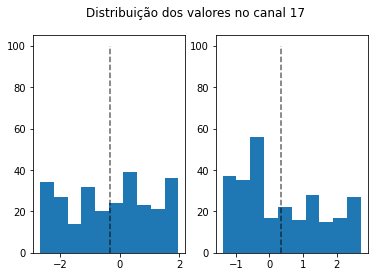

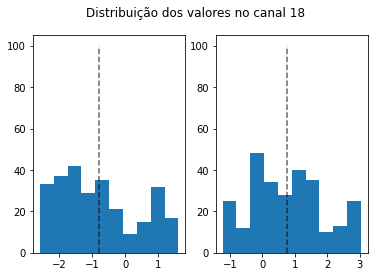

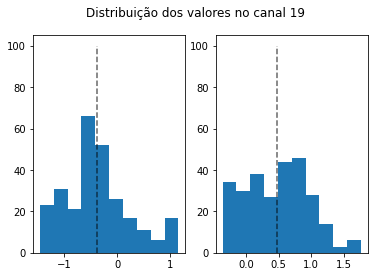

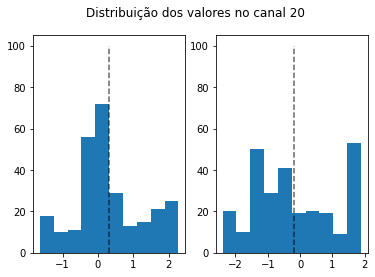

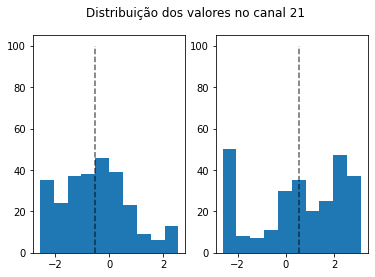

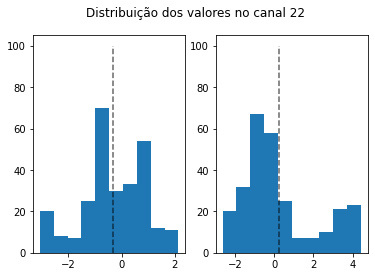

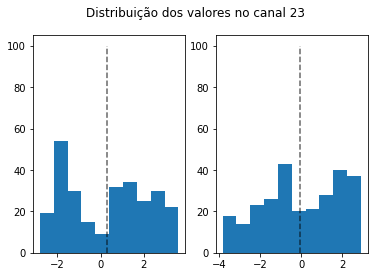

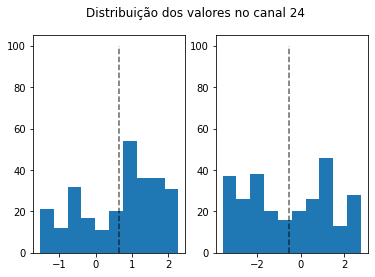

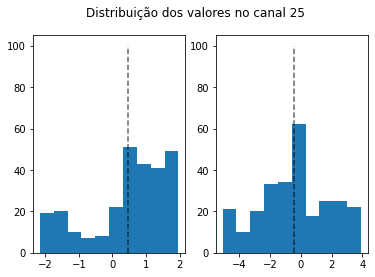

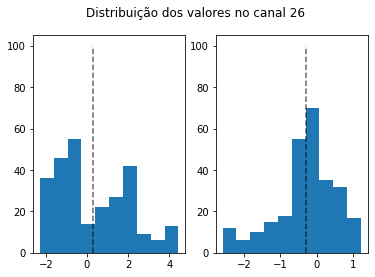

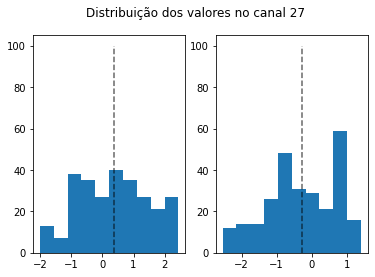

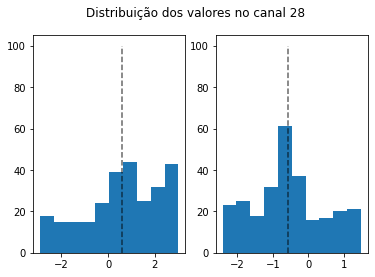

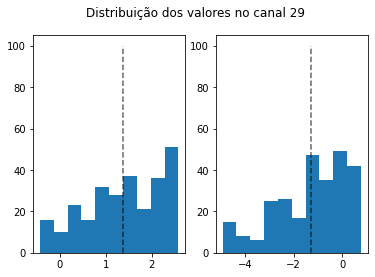

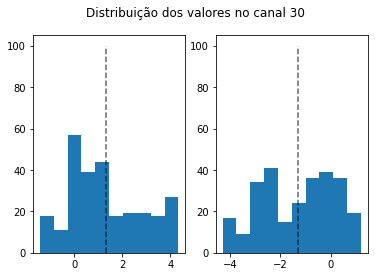

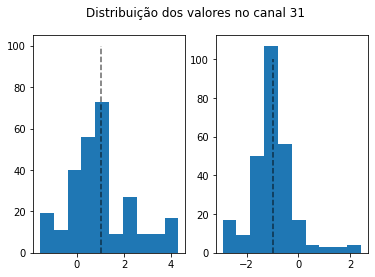

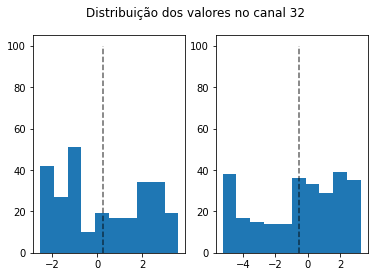

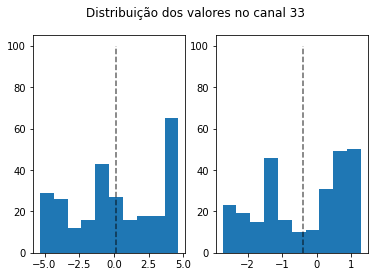

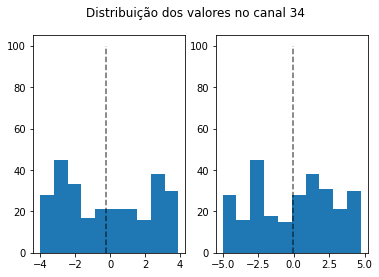

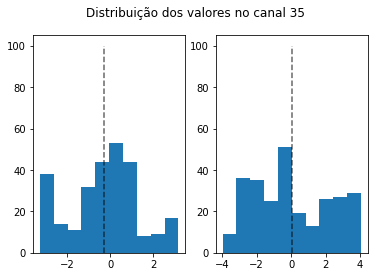

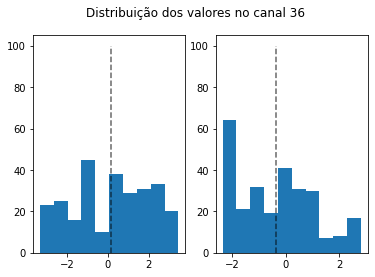

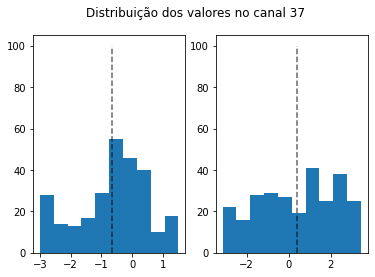

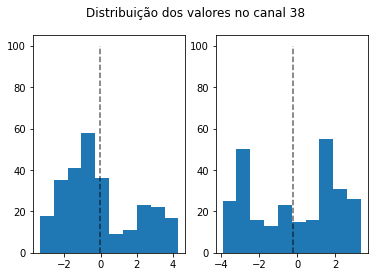

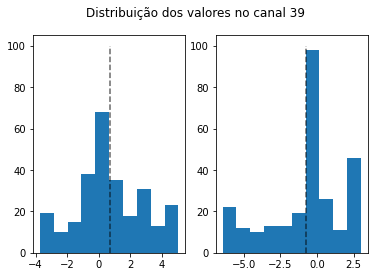

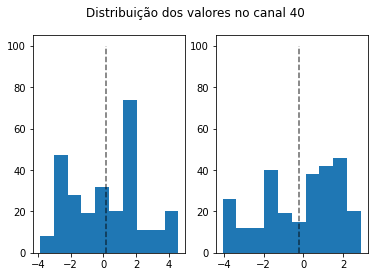

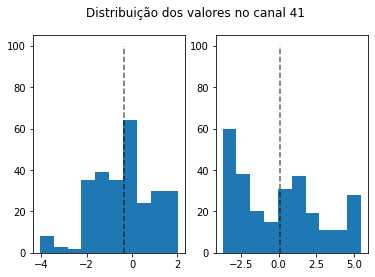

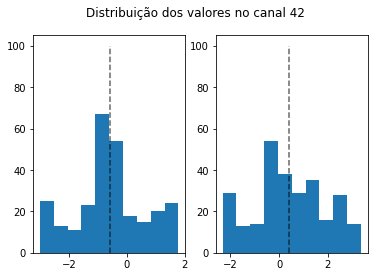

In [ ]:
for i in range(42):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle(f'Distribuição dos valores no canal {i+1}')
  ax1.hist(mediaSMedioBRANCA[i])
  ax1.vlines(mbcs[i], 0, 100, linestyles='dashed', alpha=.6)
  ax2.hist(mediaSMedioNEGRA[i])
  ax2.vlines(mngs[i], 0, 100, linestyles='dashed', alpha=.6)
  # plt.savefig(f"dist_c{i+1}.jpg")
  plt.show()

# Testes estatísticos

Considerando como válidos apenas os canais *22, 26, 32, 33 e 34*, estou realizando dois testes para comparar [as médias d]as distribuições de mãos brancas e negras.

O teste-t considera uma distribuição normal dos dados.

O teste de Wilcoxon considera que os dados não seguem a distribuição normal.

Quanto à correção de Bonferroni, pelo material que consultei, não é necessário que seja aplicada, já que não há múltiplas comparações, apenas *mãos brancas vs. mãos negras, com a HbO como variável dependente*.

In [ ]:
# Teste-t pareado

teste_t = [ttest_rel(mediaSMedioBRANCA[i], mediaSMedioNEGRA[i]) for i in range(42)]

# Todos os canais
for pos, k in enumerate(teste_t):
  m = ""
  if pos in validos:
    m = " ---->"
  print(m, "\t", pos+1, "\t", k.pvalue)

 	 1 	 0.0048974244202825935
 	 2 	 2.214828667532297e-06
 	 3 	 1.3951010940388166e-20
 	 4 	 1.806814896421385e-24
 	 5 	 3.5815205514033636e-05
 	 6 	 1.4022002775205291e-46
 	 7 	 1.36344217315981e-19
 	 8 	 9.60019085292328e-15
 	 9 	 2.504572188150286e-06
 	 10 	 0.1158401210270816
 	 11 	 7.373075545382861e-46
 	 12 	 1.2592308164494023e-08
 	 13 	 2.2694631619757785e-44
 	 14 	 3.2998019131767793e-38
 	 15 	 1.4095935918137729e-44
 	 16 	 5.905798194537379e-76
 	 17 	 1.1147229191787077e-11
 	 18 	 1.0279954209320531e-42
 	 19 	 4.6757097341331654e-57
 	 20 	 8.41074996449066e-07
 	 21 	 7.135772165636083e-09
 	 22 	 2.7859636861348144e-08
 ----> 	 23 	 1.4512775604051164e-05
 	 24 	 1.1488038932757994e-31
 	 25 	 4.110395272354652e-06
 	 26 	 5.123829347400464e-07
 ----> 	 27 	 1.341685377602521e-10
 	 28 	 1.0049538780073388e-31
 ----> 	 29 	 4.9088151019539065e-87
 	 30 	 1.7066784981344896e-40
 	 31 	 8.157375554341634e-53
 	 32 	 3.584773648407812e-11
 ----> 	 33 	 0.00033

In [ ]:
# Teste de Wilcoxon-Mann-Whitney
wilc = [wilcoxon(mediaSMedioBRANCA[i], mediaSMedioNEGRA[i]) for i in range(42)]

# Todos os canais
for pos, k in enumerate(wilc):
  m = ""
  if pos in validos:
    m = " ---->"
  print(m, "\t", pos+1, "\t", k[1])


# Apenas os canais de interesse
# for pos, k in enumerate(wilc):
#   if pos in validos:
#     print(pos+1, "\t", k[1])



 	 1 	 0.01212757133451805
 	 2 	 2.5389976525083368e-06
 	 3 	 1.6674671070657633e-17
 	 4 	 1.3177268622760975e-20
 	 5 	 0.0005513833435094359
 	 6 	 4.351612740710553e-35
 	 7 	 1.0337291358436926e-15
 	 8 	 1.924640127898619e-13
 	 9 	 3.849965683049873e-06
 	 10 	 0.0007276655975128855
 	 11 	 4.1241245046340774e-33
 	 12 	 1.8530642637542728e-06
 	 13 	 2.8390728921757364e-39
 	 14 	 6.849297325856243e-30
 	 15 	 1.592010555202935e-36
 	 16 	 2.8872379452982612e-43
 	 17 	 3.4503370554828603e-10
 	 18 	 6.8539332977522555e-37
 	 19 	 1.901374613708925e-39
 	 20 	 9.117116909217087e-06
 	 21 	 1.826609596374132e-08
 	 22 	 0.0010465159797004781
 ----> 	 23 	 1.8250733342673604e-05
 	 24 	 2.157694190318542e-25
 	 25 	 3.4262278310659853e-06
 	 26 	 4.631377392577118e-05
 ----> 	 27 	 1.5303803120984461e-09
 	 28 	 2.7798127930138784e-25
 ----> 	 29 	 4.927374817504415e-46
 	 30 	 1.3787724477657618e-31
 	 31 	 9.606589114164838e-37
 	 32 	 1.1114605501355112e-09
 ----> 	 33 	 0.0

In [ ]:
final = pd.DataFrame({"Canal": [i+1 for i in range(42)], "Teste-t": [i[1] for i in teste_t], "Wilcoxon": [i[1] for i in wilc]})

final
# final.iloc[validos]

,Canal,Teste-t,Wilcoxon
0,1,4.897424e-03,1.212757e-02
1,2,2.214829e-06,2.538998e-06
2,3,1.395101e-20,1.667467e-17
3,4,1.806815e-24,1.317727e-20
4,5,3.581521e-05,5.513833e-04
5,6,1.402200e-46,4.351613e-35
6,7,1.363442e-19,1.033729e-15
7,8,9.600191e-15,1.924640e-13
8,9,2.504572e-06,3.849966e-06
9,10,1.158401e-01,7.276656e-04


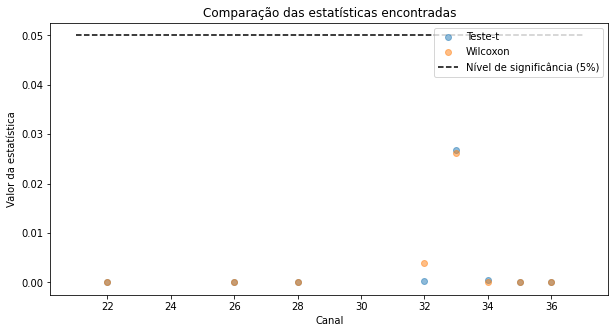

In [ ]:
plt.figure(figsize=(10, 5))

plt.scatter(y=final['Teste-t'][validos], x=[k for k in validos], alpha=.5) #
plt.scatter(y=final['Wilcoxon'][validos], x=[k for k in validos], alpha=.5) #
plt.hlines(.05, 21, 37, linestyles="dashed") # comentar

plt.legend(['Teste-t', 'Wilcoxon', 'Nível de significância (5%)'])
plt.title("Comparação das estatísticas encontradas")
plt.xlabel("Canal")
plt.ylabel("Valor da estatística")
plt.show()

In [ ]:
final['Teste-t (Bonferroni)'] = [pval_t[i] for i in range(42)]
final['Wilcoxon (Bonferroni)'] = [pval_w[i] for i in range(42)]


In [ ]:
# final[(final['Teste-t'] > .05) | (final['Teste-t (Bonferroni)'] > .05) | (final['Wilcoxon'] > .05) | (final['Wilcoxon (Bonferroni)'] > .05)]
final.iloc[[k-1 for k in validos]]

,Canal,Teste-t,Wilcoxon,Teste-t (Bonferroni),Wilcoxon (Bonferroni)
21,22,2.785964e-08,1.046516e-03,1.170105e-06,4.395367e-02
25,26,5.123829e-07,4.631377e-05,2.152008e-05,1.945179e-03
27,28,1.004954e-31,2.779813e-25,4.220806e-30,1.167521e-23
31,32,3.584774e-11,1.111461e-09,1.505605e-09,4.668134e-08
32,33,3.377485e-04,3.891411e-03,1.418544e-02,1.634392e-01
33,34,2.678743e-02,2.623961e-02,1.000000e+00,1.000000e+00
34,35,4.349136e-04,3.249346e-05,1.826637e-02,1.364725e-03
35,36,2.056707e-12,9.506768e-13,8.638171e-11,3.992843e-11


In [ ]:
meds = pd.DataFrame({"B": mbcs, "N": mngs})

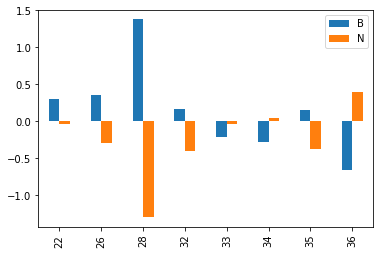

In [ ]:
ax = meds.iloc[validos].plot.bar()